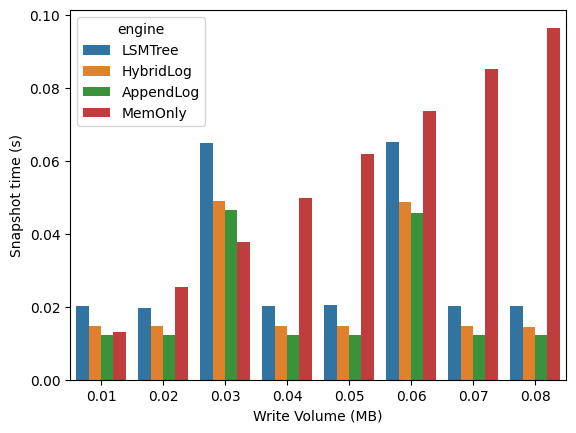


\begin{figure}[h]
    \centering
    \includegraphics[width=0.25\textwidth]{snapshot.png}
    \caption{snapshot.png}
    \label{fig:snapshot.png}
\end{figure}



In [1]:
# when state is the zero and we only do updates

import sys
sys.path.append('..')
from utils import *
from distributions import Uniform, Zipfian, HotSet
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathReplica, SimpleReplica

import seaborn as sns
import matplotlib.pyplot as plt


def measure_snapshot_time(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    rng = Random(1)
    klen = 2
    vlen = 8
    start = 1_000
    incr = 1_000
    n = 7

    size_so_far = 0
    aggr_time = 0

    for _ in range(start):
        db[rng.randbytes(klen)] = rng.randbytes(vlen)
    with Timer() as t:
        db.snapshot()
    size_so_far += start * (klen + vlen)
    aggr_time += float(t)
    row = {'metric': 'snapshot', 'value': float(t), 'write_volume': size_so_far / 1_000_000}
    res.append(row)
    row = {'metric': 'snapshot_aggr', 'value': aggr_time, 'write_volume': size_so_far / 1_000_000}
    res.append(row)

    for _ in range(n):
        for _ in range(incr):
            db[rng.randbytes(klen)] = rng.randbytes(vlen)
        with Timer() as t:
            db.snapshot()
        size_so_far += incr * (klen + vlen)
        aggr_time += float(t)
        row = {'metric': 'snapshot', 'value': float(t), 'write_volume': size_so_far / 1_000_000}
        res.append(row)
        row = {'metric': 'snapshot_aggr', 'value': aggr_time, 'write_volume': size_so_far / 1_000_000}
        res.append(row)

    return res

latency = 10**(-6)
df = run(
    [2], [8], [1], [1],
    [Uniform], [{'seed': [1]}],
    [LSMTree, HybridLog, AppendLog, MemOnly], [{
        'auto_push': [False],
        'max_runs_per_level': [3],
        'density_factor': [10],
        'memtable_bytes_limit': [1_000_000],
        'replica': [SimpleReplica('./benchmark_data_' + LSMTree.name, '/tmp/remote', network_latency_per_byte=latency)]
    },
    {
        'auto_push': [False],
        'max_runs_per_level': [3],
        'mem_segment_len': [210_000],
        'ro_lag_interval': [100_000],
        'flush_interval': [100_000],
        'hash_index': ['dict'],
        'compaction_enabled': [False],
        'replica': [SimpleReplica('./benchmark_data_' + HybridLog.name, '/tmp/remote', network_latency_per_byte=latency)]
    },
    {
        'auto_push': [False],
        'max_runs_per_level': [3],
        'threshold': [1_000_000],
        'replica': [SimpleReplica('./benchmark_data_' + AppendLog.name, '/tmp/remote', network_latency_per_byte=latency)]
    },
    {
        'replica': [SimpleReplica('./benchmark_data_' + MemOnly.name, '/tmp/remote', network_latency_per_byte=latency)]
    }],
    [measure_snapshot_time], {}
)


data = df[['write_volume', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['snapshot'])]

barplot(data, 'write_volume', 'value', 'snapshot',
         hue='engine',
         X='Write Volume (MB)', Y='Snapshot time (s)',
         save=True, show=True)

/tmp/benchmarks/utils.py:156: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=30)


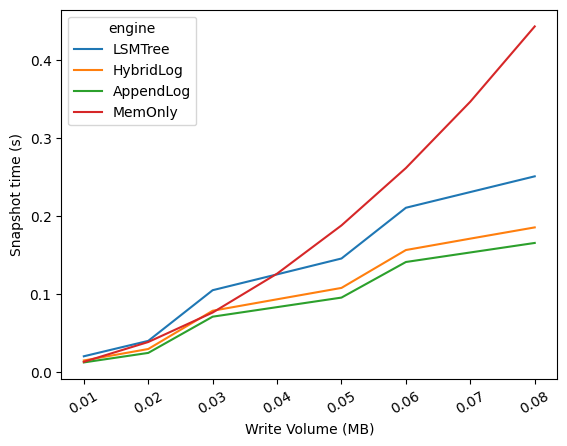


\begin{figure}[H]
    \centering
    \includegraphics[width=0.6\textwidth]{snapshot-aggr.png}
    \caption{snapshot-aggr}
    \label{fig:snapshot-aggr}
\end{figure}



In [2]:
data = df[['write_volume', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['snapshot_aggr'])]

lineplot(data, 'write_volume', 'value', 'snapshot-aggr',
         hue='engine', rotatex=True,
         X='Write Volume (MB)', Y='Snapshot time (s)',
         save=True, show=True)

In [ ]:
# when state is the same and we only do updates

import sys
sys.path.append('..')
from utils import *
from distributions import Uniform, Zipfian, HotSet
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathReplica, SimpleReplica

import seaborn as sns
import matplotlib.pyplot as plt


def measure_snapshot_time(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    rng = Random(1)
    klen = 2
    vlen = 8
    start = 100_000_000
    incr = 1_000
    n = 20

    size_so_far = 0
    aggr_time = 0

    for _ in range(start):
        db[rng.randbytes(klen)] = rng.randbytes(vlen)
    with Timer() as t:
        db.snapshot()
    size_so_far += start * (klen + vlen)
    aggr_time += float(t)
    print(size_so_far)
    row = {'metric': 'snapshot', 'value': float(t), 'write_volume': size_so_far}
    res.append(row)
    row = {'metric': 'snapshot_aggr', 'value': aggr_time, 'write_volume': size_so_far}
    print(db.name, row)
    res.append(row)

    for _ in range(n):
        for _ in range(incr):
            db[rng.randbytes(klen)] = rng.randbytes(vlen)
        with Timer() as t:
            db.snapshot()
        size_so_far += incr * (klen + vlen)
        aggr_time += float(t)
        row = {'metric': 'snapshot', 'value': float(t), 'write_volume': size_so_far}
        res.append(row)
        row = {'metric': 'snapshot_aggr', 'value': aggr_time, 'write_volume': size_so_far}
        # print(db.name, row)
        res.append(row)

    return res

latency = 10**(-6)
df = run(
    [2], [8], [1], [1],
    [Uniform], [{'seed': [1]}],
    [LSMTree, HybridLog, AppendLog, MemOnly], [{
        'auto_push': [False],
        'max_runs_per_level': [3],
        'density_factor': [10],
        'memtable_bytes_limit': [1_000_000],
        'replica': [SimpleReplica('./benchmark_data_' + LSMTree.name, '/tmp/remote', network_latency_per_byte=latency)]
    },
    {
        'auto_push': [False],
        'max_runs_per_level': [3],
        'mem_segment_len': [210_000],
        'ro_lag_interval': [100_000],
        'flush_interval': [100_000],
        'hash_index': ['dict'],
        'compaction_enabled': [False],
        'replica': [SimpleReplica('./benchmark_data_' + HybridLog.name, '/tmp/remote', network_latency_per_byte=latency)]
    },
    {
        'auto_push': [False],
        'max_runs_per_level': [3],
        'threshold': [1_000_000],
        'replica': [SimpleReplica('./benchmark_data_' + AppendLog.name, '/tmp/remote', network_latency_per_byte=latency)]
    },
    {
        'replica': [SimpleReplica('./benchmark_data_' + MemOnly.name, '/tmp/remote', network_latency_per_byte=latency)]
    }],
    [measure_snapshot_time], {}
)


data = df[['write_volume', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['snapshot'])]
data['write_volume'] = data['write_volume'] / 1000000000

p=sns.lineplot(x='write_volume', data=data, y='value', hue='engine')
p.set_xticklabels([float(l.get_text().replace('−', '-')) + 1 for l in p.get_xticklabels()], rotation=30)
p.set_xlabel('Write Volume (GB)')
p.set_ylabel('Snapshot time (s)')
p.figure.savefig("snapshot-static-state.png", bbox_inches='tight')

/tmp/ipykernel_8065/875566486.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels([float(l.get_text().replace('−', '-')) + 1 for l in p.get_xticklabels()], rotation=30)


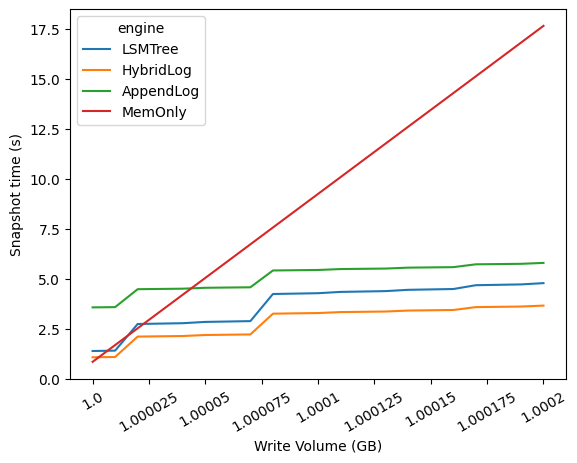

In [94]:
data = df[['write_volume', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['snapshot_aggr'])]
data['write_volume'] = data['write_volume'] / 1000000000

p=sns.lineplot(x='write_volume', data=data, y='value', hue='engine')
p.set_xticklabels([float(l.get_text().replace('−', '-')) + 1 for l in p.get_xticklabels()], rotation=30)
p.set_xlabel('Write Volume (GB)')
p.set_ylabel('Snapshot time (s)')
p.figure.savefig("snapshot-static-state-aggr.png", bbox_inches='tight')

/tmp/ipykernel_8065/860174348.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels([float(l.get_text().replace('−', '-')) + 1 for l in p.get_xticklabels()], rotation=30)


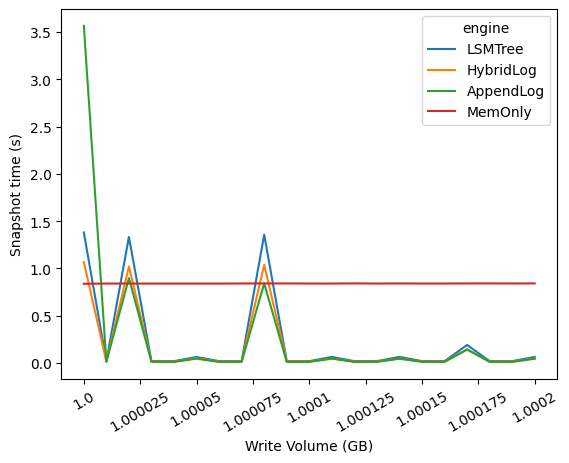

In [95]:
data = df[['write_volume', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['snapshot'])]
data['write_volume'] = data['write_volume'] / 1000000000

p=sns.lineplot(x='write_volume', data=data, y='value', hue='engine')
p.set_xticklabels([float(l.get_text().replace('−', '-')) + 1 for l in p.get_xticklabels()], rotation=30)
p.set_xlabel('Write Volume (GB)')
p.set_ylabel('Snapshot time (s)')
p.figure.savefig("snapshot-static-state.png", bbox_inches='tight')